### **Quantum Phase Estimation**

<br>

**Goal** : Estimate the phase $\theta$ in the eigenvalue equation:
$$
U|\psi\rangle = e^{i 2\pi \theta} |\psi\rangle
$$

<br>

---


In [104]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

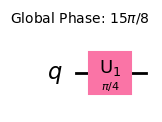

In [105]:
from qiskit.circuit.library import RZGate
import numpy as np

phi = 1/8
n_qubits = 3

U_gate = RZGate(2 * np.pi * phi)
U_gate.name="U"
U_gate.label='U'

U_gate.definition.draw("mpl")

**2. Inverse QFT circuit**

<br>

---

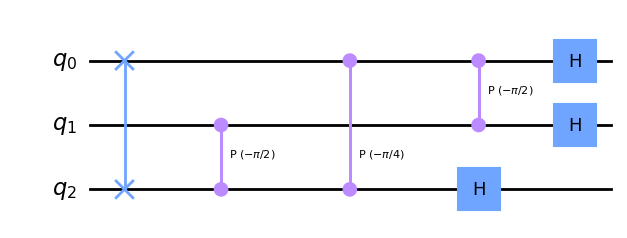

In [106]:
from qiskit import QuantumCircuit

def qft_dagger(n):
    qc = QuantumCircuit(n)
    
    for i in range( n // 2):
        qc.swap(i, n-1-i)
    
    for i in reversed(range(n)):
        for j in reversed(range(i)):
            qc.cp(-np.pi / (2**(i-j)), j, i)
        qc.h(i)

    iqft = qc.to_gate()
    iqft.label = "QFT†"
    return iqft

qft_gate = qft_dagger(n_qubits)
qft_gate.definition.draw("mpl")

**3. QPE circuit**

---

<br>

**1. Initialization:** Start first $n$ qubit in $|0\rangle$ and prepare the eigen state $|\psi\rangle$


**2. Superposition:** Prepare $n$ counting qubits in the superposition state:


**3. Controlled Phase Accumulation:**
For eigenstates, applying the unitary operator $U$ repeatedly ($2^k$ times) contributes only a global phase:
$$
U^{2^k}|\psi\rangle = e^{i 2\pi \theta 2^k} |\psi\rangle
$$
Thus, the **Controlled-**$U^{2^k}$ gate effectively acts as a phase rotation on the control qubit:
$$
\text{Controlled-}R_z(2\pi \theta \cdot 2^k)
$$
This encodes the phase information $\theta$ into the relative phases of the counting qubits.

<br>

**4. Inverse QFT**
The Inverse Quantum Fourier Transform ($QFT^\dagger$) acts on the counting register to convert the encoded phase information into a measurable binary integer state $m$:
$$
\frac{m}{2^n} \approx \theta
$$

**5. Measurement**
1. **Measure** the counting qubits to obtain the bitstring $b_{LSB \to MSB}$.
2. **Convert** the integer value to the phase estimate:
$$
\hat{\theta} = \frac{\text{int}(b_{\text{rev}}, 2)}{2^n}
$$

---

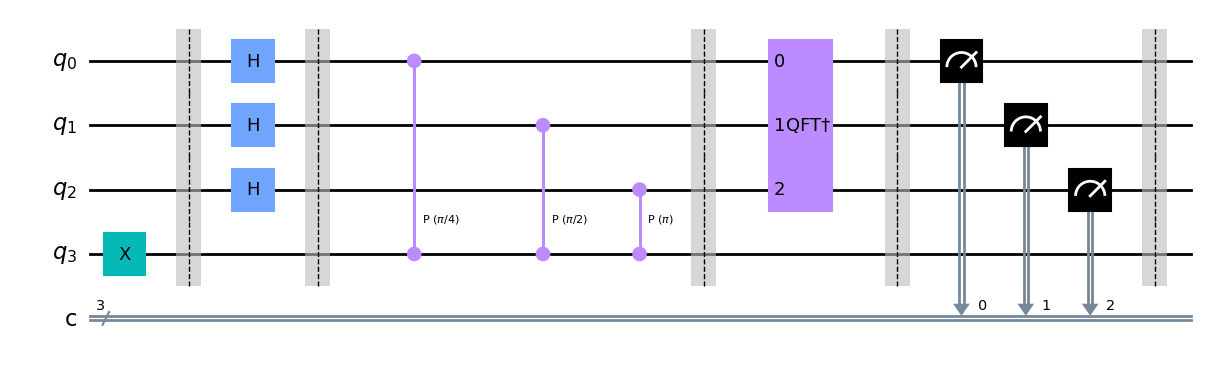

In [107]:


def qpe_circuit(U_gate, t, theta):
    qc = QuantumCircuit(t+1, t)

    # 1. prepare eigenstate
    qc.x(t)
    qc.barrier()

    # 2. superposition
    for i in range(t):
        qc.h(i)
    qc.barrier()

    # 3. controlled-U^(2^i)
    for i in range(t):
        qc.cp(2 * np.pi * theta * (2**i), i, t)
    qc.barrier()

    # 4. inverse QFT
    qc.append(qft_dagger(t), range(t))
    qc.barrier()

    # 5. measurement
    qc.measure(range(t), range(t))
    qc.barrier()

    return qc

qc_qpe = qpe_circuit(U_gate, n_qubits, phi)
qc_qpe.draw("mpl")


**4. simulation on Ideal simulator**

<br>

---


True θ = 0.125
Estimated θ = 0.125

QPE Error = 0.0
counts: {'101': 19, '011': 121, '111': 129, '001': 1004, '110': 137, '100': 134, '000': 382, '010': 122}


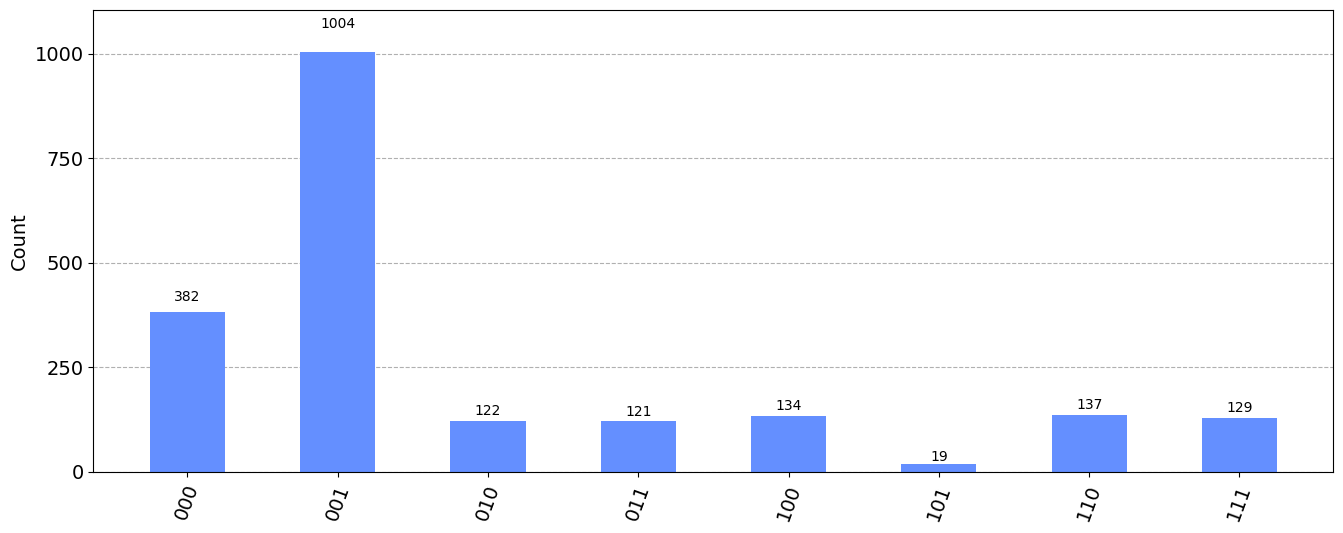

In [108]:

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

simulator = AerSimulator()
compiled = transpile(qc_qpe, simulator)

job = simulator.run(compiled, shots=2048)
result = job.result()
counts = result.get_counts()
max_key = max(counts, key=counts.get)
estimate = int(max_key, 2) / (2**n_qubits)

print("\nTrue θ =", phi)
print("Estimated θ =", estimate)
print("\nQPE Error =", abs(phi - estimate))

print("counts:", counts)
plot_histogram(counts, figsize=(16, 6))


**5. simulation on Noise models**

<br>

---


True θ = 0.125
Estimated θ = 0.125

QPE Error = 0.0
counts: {'111': 110, '011': 187, '110': 143, '001': 832, '100': 137, '000': 402, '010': 150, '101': 87}


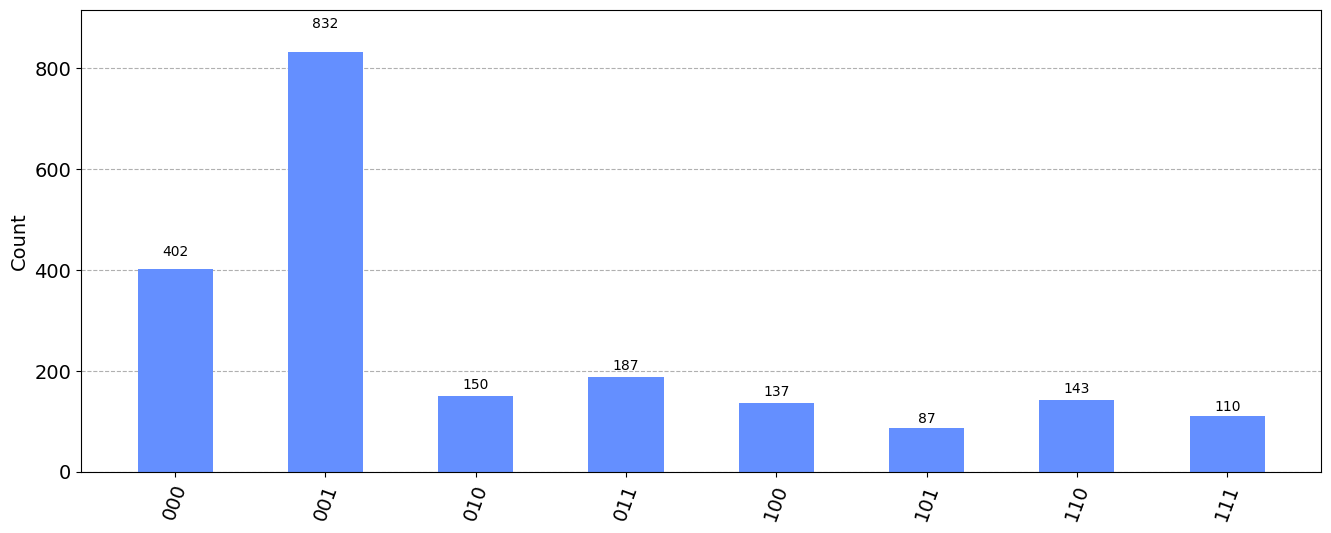

In [109]:

from qiskit.providers.fake_provider import FakeKolkata
from qiskit_aer.noise import NoiseModel

fake_backend = FakeKolkata()
noise_model = NoiseModel.from_backend(fake_backend)
basis_gates = noise_model.basis_gates
coupling_map = fake_backend.configuration().coupling_map

sim_noise = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, coupling_map=coupling_map)

compiled = transpile(qc_qpe, sim_noise)
job = sim_noise.run(compiled, shots=2048)
result = job.result()
counts = result.get_counts()
max_key = max(counts, key=counts.get)
estimate = int(max_key, 2) / (2**n_qubits)

print("\nTrue θ =", phi)
print("Estimated θ =", estimate)
print("\nQPE Error =", abs(phi - estimate))

print("counts:", counts)
plot_histogram(counts, figsize=(16, 6))